# 汽车里程数回归预测实验

本实验以开源的auto-mpg数据集为基础，基于MindSpore深度学习库应用全连接神经网络进行汽车里程数预测。

## 1、实验目的

- 掌握全连接神经网络的原理。
- 了解如何使用MindSpore进行简单的回归模型的训练。
- 了解如何使用MindSpore进行简单的回归模型的预测。

## 2、全连接神经网络的原理介绍

浅层神经网络相比单层网络的差别在于隐藏层有多个神经节点，这就使得其可以处理“多输入多输出”的复杂问题。每一层的每一个节点都与上下层节点全部连接，这种神经网络称作全连接网络。

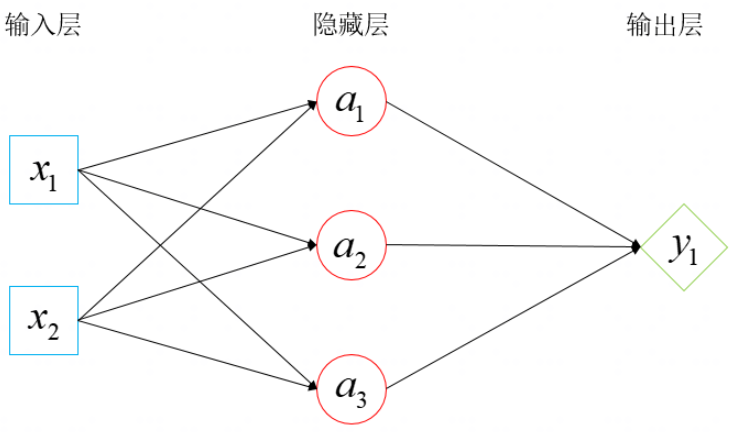

### 2.1 正向传播

$$z^{[1]} = \left\lgroup\begin{matrix}z_{1}^{[1]} \cr z_{2}^{[2]} \cr z_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}w_{1}^{[1]T}\cdot x + b_{1}^{[1]} \cr w_{2}^{[2]T}\cdot x + b_{2}^{[2]} \cr w_{3}^{[3]T}\cdot x + b_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}w_{1}^{[1]T}\cdot x \cr w_{2}^{[2]T}\cdot x \cr w_{3}^{[3]T}\cdot x  \end{matrix}\right\rgroup + b^{[1]} = W^{[1]}X + b^{[1]}$$



$$a^{[1]} = \left\lgroup\begin{matrix}a_{1}^{[1]} \cr a_{2}^{[2]} \cr a_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}t\left(z_{1}^{[1]}\right) \cr t\left(z_{2}^{[2]}\right) \cr t\left(z_{3}^{[3]}\right)\end{matrix}\right\rgroup = t\left\lgroup\begin{matrix}\left(z_{1}^{[1]}\right) \cr \left(z_{2}^{[2]}\right) \cr \left(z_{3}^{[3]}\right) \end{matrix}\right\rgroup = t\left(z^{[1]}\right)$$

- 上角标中括号用于区分不同层
- 下角标数字表示神经元节点的映射关系
- 一个神经元节点包含上一层节点数$w$和$b$和下一层节点数$z$

### 2.2 反向传播

梯度下降法：

$$W = W - \alpha  \frac{\partial L}{\partial W}$$
$$b = b - \alpha  \frac{\partial L}{\partial b}$$

式中$W$和$b$为模型的权重参数，$L$为模型定义的损失函数，$\alpha$为超参数学习率；以上两式可以理解为：通过损失函数$L$对权重参数$W$和$b$进行求取导数，并利用导数乘以学习率对原来的$W$和$b$进行更新。

In [2]:
pip install download


Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/MindSpore/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 3、实验环境

- MindSpore 2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 本案例支持win_x86和Linux系统，CPU/Ascend均可运行。
- 如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4、数据处理

### 4.1数据准备

这个数据集来自卡内基梅隆大学维护的StatLib库。1983年美国统计协会博览会使用了该数据集。这个数据集是对StatLib库中提供的数据集稍加修改的版本。根据Ross Quinlan(1993)在预测属性“mpg”中的使用，删除了 8 个原始实例，因为它们的“mpg”属性值未知。原始数据集在“auto-mpg.data-original”文件中。

该数据集共计9个特征，398个样本，用于回归任务。

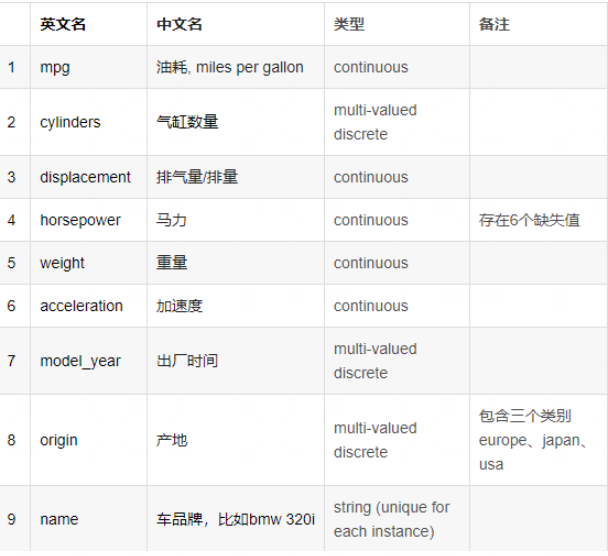

In [3]:
from download import download

# 下载汽车里程auto-mpg数据集
url = " https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/deep-learning/auto-mpg.zip"  
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 6.68k/6.68k [00:00<00:00, 4.28MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 4.2数据加载

- 导入模型库：

os模块主要用于对系统路径和文件进行处理。Numpy模块主要用于数据的基本运算操作。Matplotlib模块主要用于画图。MindSpore相关模块主要用于搭建网络、调用优化器、读取数据集和将数据集处理成网络的标准输入格式。

In [1]:
#导入相关依赖库
import  os
import csv
import time
import numpy as np
import pandas as pd  #版本采用1.3.0
from matplotlib import pyplot as plt

import mindspore as ms
import mindspore.dataset as ds
from mindspore.dataset import GeneratorDataset
import mindspore.dataset.transforms as C
import mindspore.dataset.vision as CV

from mindspore import nn, Tensor, ops
from mindspore.train import Model

from mindspore import load_checkpoint, load_param_into_net
from mindspore.train import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

ms.set_context(mode=ms.GRAPH_MODE, device_target='CPU')  # device_target支持"Ascend"、"CPU"。

- 查看数据格式

In [2]:
#加载数据集
with open('./auto-mpg.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[20:40]) # 打印部分数据

[['25.0   4   110.0      87.00      2672.      17.5   70  2\t"peugeot 504"'], ['24.0   4   107.0      90.00      2430.      14.5   70  2\t"audi 100 ls"'], ['25.0   4   104.0      95.00      2375.      17.5   70  2\t"saab 99e"'], ['26.0   4   121.0      113.0      2234.      12.5   70  2\t"bmw 2002"'], ['21.0   6   199.0      90.00      2648.      15.0   70  1\t"amc gremlin"'], ['10.0   8   360.0      215.0      4615.      14.0   70  1\t"ford f250"'], ['10.0   8   307.0      200.0      4376.      15.0   70  1\t"chevy c20"'], ['11.0   8   318.0      210.0      4382.      13.5   70  1\t"dodge d200"'], ['9.0    8   304.0      193.0      4732.      18.5   70  1\t"hi 1200d"'], ['27.0   4   97.00      88.00      2130.      14.5   71  3\t"datsun pl510"'], ['28.0   4   140.0      90.00      2264.      15.5   71  1\t"chevrolet vega 2300"'], ['25.0   4   113.0      95.00      2228.      14.0   71  3\t"toyota corona"'], ['25.0   4   98.00      ?          2046.      19.0   71  1\t"ford pinto"'], ['

- 利用pandas模块读取数据

Pandas模块是一个处理表格类数据非常有效的模块。

In [3]:
#使用pandas读取数据
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
#遇到？换成nan，忽略\t之后的内容，已空格作为分隔符。
raw_data = pd.read_csv('./auto-mpg.data', names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

data = raw_data.copy()

#查看数据形状
data.shape

(398, 8)

- 数据预处理

对于数据集中的空值，我们要在建模前进行处理。此处空值的数据较少，我们直接进行删除。特征Origin代表着车辆的归属区域信息，此处总共分为三种，欧洲，美国，日本，我们需要对此特征进行one-hot编码。

In [4]:
#对于数据集中的空值，我们要在建模前进行处理。此处空值的数据较少，我们直接进行删除。
#清洗空数据
data = data.dropna()
data.tail()
#Pandas库提供了简单的数据集统计信息，我们可直接调用函数describe()进行查看。
#查看训练数据集的结构
origin = data.pop('Origin')
data_labels = data.pop('MPG')
train_stats = data.describe()
train_stats = train_stats.transpose()
train_stats
#归一化数据
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(data)
# 将MPG放回归一化后的数据中
normed_data['MPG'] = data_labels
# 离散特征处理
# 特征Origin代表着车辆的归属区域信息，此处总共分为三种，欧洲，美国，日本，我们需要对此特征进行one-hot编码。
# 对origin属性进行one-hot编码
normed_data['USA'] = (origin == 1)*1.0
normed_data['Europe'] = (origin == 2)*1.0
normed_data['Japan'] = (origin == 3)*1.0

模型训练需要区分特征值与目标值，也就是我们常说的X值与Y值，此处MPG为Y值，其余的特征为X值。

在模型构建的时候，我们一般需要准备两份数据，一份训练集数据用于模型的训练构建，一份测试集用于模型的评估优化。创建比例0.8，用于分割训练集和验证集，80%的数据用于模型训练，20%的数据用于模型验证。并把数据集处理成模型所需的数据格式。

In [5]:
#将数据集按照4：1划分成训练集和测试集
train_dataset = normed_data.sample(frac=0.8,random_state=0)
test_dataset = normed_data.drop(train_dataset.index)

#模型训练需要区分特征值与目标值，也就是我们常说的X值与Y值，此处MPG为Y值，其余的特征为X值。
#将目标值和特征分开
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

X_train, Y_train = np.array(train_dataset, dtype=np.float32), np.array(train_labels, dtype=np.float32)
X_test, Y_test = np.array(test_dataset, dtype=np.float32), np.array(test_labels, dtype=np.float32)

#查看数据集尺寸
print('训练数据x尺寸：',X_train.shape)
print('训练数据y尺寸：',Y_train.shape)
print('测试数据x尺寸：',X_test.shape)
print('测试数据y尺寸：',Y_test.shape)

训练数据x尺寸： (314, 9)
训练数据y尺寸： (314,)
测试数据x尺寸： (78, 9)
测试数据y尺寸： (78,)


In [6]:
# Iterable object as input source
class Iterable:
    def __init__(self, X, Y):
        self._data = X
        self._label = Y[:, np.newaxis]

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)

data = Iterable(X_train, Y_train)
dataset_train = GeneratorDataset(source=data, column_names=["data", "label"])
data = Iterable(X_test, Y_test)
dataset_test = GeneratorDataset(source=data, column_names=["data", "label"])

## 5、模型构建

汽车油耗里程数据集准备完成，接下来我们就需要构建训练模型，本实验采用的是全连接神经网络算法，所以我们首先需要建立初始化的神经网络。nn.cell能够用来组成网络模型;模型共包含3个全连接，采用Relu当做激活函数。

In [10]:
# 定义网络
class Regression_car(nn.Cell):
    def __init__(self):
        super(Regression_car, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(9,64, activation='relu')
        self.fc2 = nn.Dense(64,64, activation='relu')
        self.fc3 = nn.Dense(64,1)
        
        
    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [11]:
# 定义网络
class Regression_car_act(nn.Cell):
    def __init__(self):
        super(Regression_car_act, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(9,64, activation='gelu')
        self.fc2 = nn.Dense(64,64, activation='gelu')
        self.fc3 = nn.Dense(64,1)
        
        
    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [12]:
# 定义网络
class Regression_car_large(nn.Cell):
    def __init__(self):
        super(Regression_car_large, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(9,256, activation='relu')
        self.fc2 = nn.Dense(256,256, activation='relu')
        self.fc3 = nn.Dense(256,1)
        
        
    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [17]:
# 定义网络
class Regression_car_4layers(nn.Cell):
    def __init__(self):
        super(Regression_car_4layers, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(9,64, activation='relu')
        self.fc2 = nn.Dense(64,64, activation='relu')
        self.fc3 = nn.Dense(64,64, activation='relu')
        self.fc4 = nn.Dense(64,1)
        
        
    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

## 6、模型训练与测试

指定模型所需的损失函数、评估指标、优化器等参数。回归问题，损失函数采用均方误差MSE。将创建好的网络、损失函数、评估指标、优化器等参数装入模型中对模型进行训练。需要逐步打印出MAE、MSE的值。

[net1] Epoch 1
-------------------------------
loss: 645.159790  [  0/314]
loss: 195.596802  [100/314]
loss: 2.315100  [200/314]
loss: 2.539194  [300/314]
Epoch train mean loss: 285.886679
Test Avg loss: 12.166614

[net1] Epoch 2
-------------------------------
loss: 93.645348  [  0/314]
loss: 15.710172  [100/314]
loss: 6.721189  [200/314]
loss: 6.862455  [300/314]
Epoch train mean loss: 13.945589
Test Avg loss: 8.403273

[net1] Epoch 3
-------------------------------
loss: 3.746283  [  0/314]
loss: 0.000001  [100/314]
loss: 0.109420  [200/314]
loss: 0.180231  [300/314]
Epoch train mean loss: 10.922811
Test Avg loss: 9.232930

[net1] Epoch 4
-------------------------------
loss: 16.653856  [  0/314]
loss: 4.028018  [100/314]
loss: 0.160407  [200/314]
loss: 0.546700  [300/314]
Epoch train mean loss: 9.870561
Test Avg loss: 7.590159

[net1] Epoch 5
-------------------------------
loss: 7.763631  [  0/314]
loss: 1.570320  [100/314]
loss: 0.437931  [200/314]
loss: 0.112563  [300/314]
Epoch

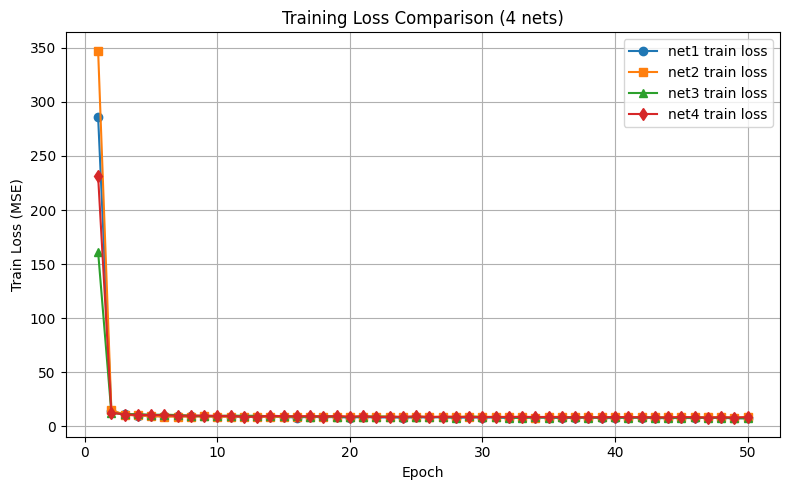

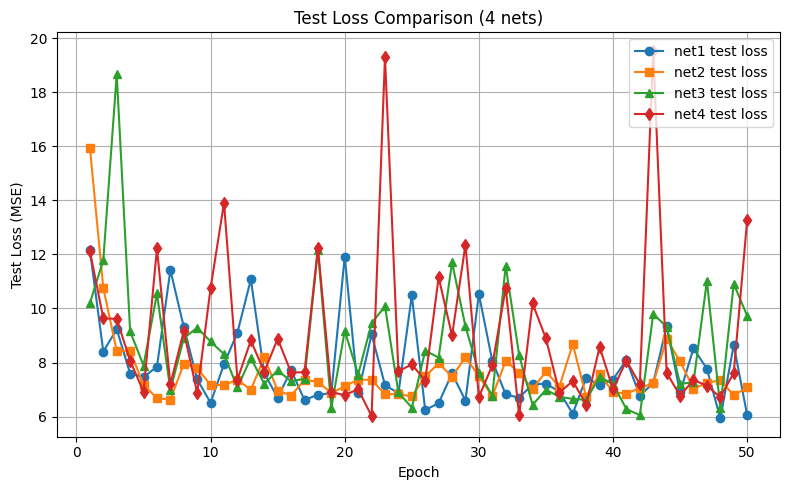

[net1] Test MSE: 6.059235, MAE: 1.801548
[net2] Test MSE: 7.079914, MAE: 1.902016
[net3] Test MSE: 9.733151, MAE: 2.403214
[net4] Test MSE: 13.261495, MAE: 2.789574


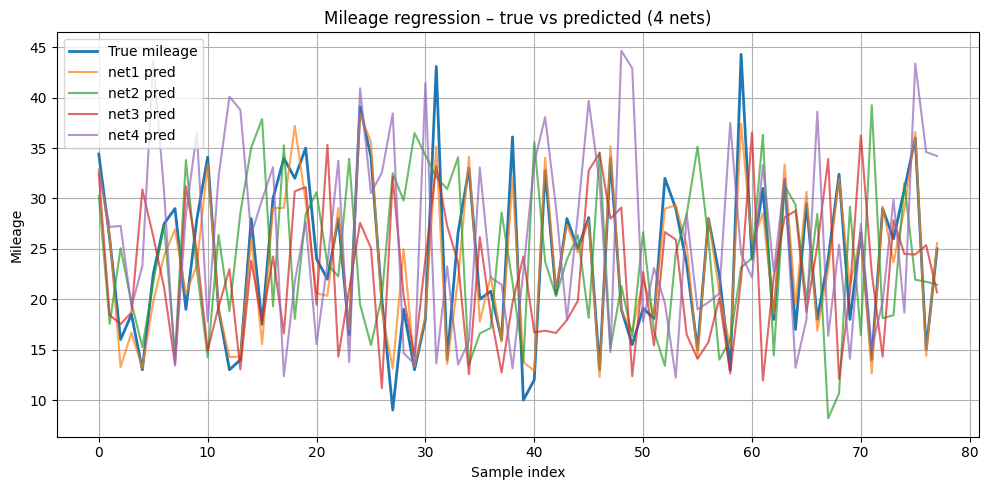

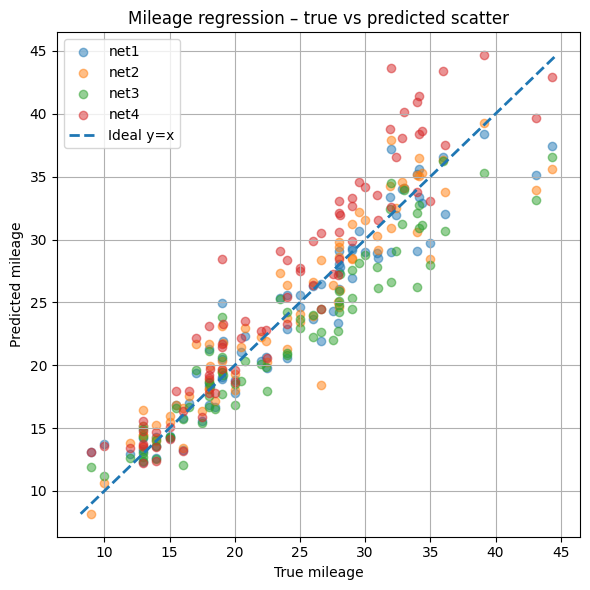

In [25]:
import mindspore as ms
from mindspore import nn
import numpy as np
import matplotlib.pyplot as plt

# 定义网络、loss、优化器
network1 = Regression_car()
net1_loss_fn = nn.MSELoss()
net1_opt = nn.RMSProp(network1.trainable_params(), 0.001)

# 比如你还有一个改进版网络 network2
network2 = Regression_car_act()  # 这里假设你自己定义了这个类
net2_loss_fn = nn.MSELoss()
net2_opt = nn.RMSProp(network2.trainable_params(), 0.001)

# 比如你还有一个改进版网络 network2
network3 = Regression_car_large()  # 这里假设你自己定义了这个类
net3_loss_fn = nn.MSELoss()
net3_opt = nn.RMSProp(network3.trainable_params(), 0.001)

network4 = Regression_car_4layers()  # 这里假设你自己定义了这个类
net4_loss_fn = nn.MSELoss()
net4_opt = nn.RMSProp(network4.trainable_params(), 0.001)



# ====================== 训练 & 测试循环 ======================
def train_loop(model, dataset, loss_fn, optimizer):
    """返回：本 epoch 的平均 loss（标量）以及每个 batch 的 loss 列表"""
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss

    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

    def train_step(data, label):
        loss, grads = grad_fn(data, label)
        optimizer(grads)
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    batch_losses = []

    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        # 你原来的数据维度变换
        data = ms.Tensor(data[:, np.newaxis].T, ms.float32)
        label = ms.Tensor(label[:, np.newaxis], ms.float32)

        loss = train_step(data, label)
        loss_val = float(loss.asnumpy())  # 转成 python float
        batch_losses.append(loss_val)

        if batch % 100 == 0:
            current = batch
            print(f"loss: {loss_val:>7f}  [{current:>3d}/{size:>3d}]")

    epoch_mean_loss = float(np.mean(batch_losses))
    print(f"Epoch train mean loss: {epoch_mean_loss:.6f}")
    return epoch_mean_loss, batch_losses


def test_loop(model, dataset, loss_fn):
    """返回：测试集平均 loss（标量）"""
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total_loss = 0.0

    for data, label in dataset.create_tuple_iterator():
        data = ms.Tensor(data[:, np.newaxis].T, ms.float32)
        label = ms.Tensor(label[:, np.newaxis], ms.float32)
        pred = model(data)
        batch_loss = float(loss_fn(pred, label).asnumpy())
        total_loss += batch_loss

    avg_loss = total_loss / num_batches
    print(f"Test Avg loss: {avg_loss:>8f}\n")
    return avg_loss


# ====================== 训练：收集 loss 曲线 ======================
def train_full_model(model, loss_fn, optimizer, 
                     dataset_train, dataset_test, 
                     epochs, name="net"):
    """训练一个模型，并返回它的训练 / 测试 loss 曲线"""
    train_loss_history = []
    test_loss_history = []

    for t in range(epochs):
        print(f"[{name}] Epoch {t+1}\n-------------------------------")
        epoch_train_loss, _ = train_loop(model, dataset_train, loss_fn, optimizer)
        epoch_test_loss = test_loop(model, dataset_test, loss_fn)

        train_loss_history.append(epoch_train_loss)
        test_loss_history.append(epoch_test_loss)

    print(f"[{name}] Training Done!")
    return train_loss_history, test_loss_history

# ====================== 额外：MSE / MAE 计算函数 ======================
def eval_mse_mae(model, dataset, name="net"):
    model.set_train(False)

    se_sum = 0.0   # squared error 累积
    ae_sum = 0.0   # absolute error 累积
    n = 0          # 总样本数

    for data, label in dataset.create_tuple_iterator():
        data = ms.Tensor(data[:, np.newaxis].T, ms.float32)
        label = ms.Tensor(label[:, np.newaxis], ms.float32)

        pred = model(data)

        pred_np = pred.asnumpy().reshape(-1)
        label_np = label.asnumpy().reshape(-1)

        diff = pred_np - label_np
        se_sum += np.sum(diff ** 2)
        ae_sum += np.sum(np.abs(diff))
        n += diff.size

    mse = se_sum / n
    mae = ae_sum / n
    print(f"[{name}] Test MSE: {mse:.6f}, MAE: {mae:.6f}")
    return mse, mae


# ====================== 额外：取预测值和真实值 ======================
def get_preds_and_labels(model, dataset):
    """从测试集拿出该模型的所有预测值和真实值"""
    model.set_train(False)
    all_preds = []
    all_labels = []

    for data, label in dataset.create_tuple_iterator():
        data = ms.Tensor(data[:, np.newaxis].T, ms.float32)
        label = ms.Tensor(label[:, np.newaxis], ms.float32)

        pred = model(data)

        all_preds.append(pred.asnumpy().reshape(-1))
        all_labels.append(label.asnumpy().reshape(-1))

    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_labels, axis=0)
    return y_true, y_pred


# ====================== 训练四个网络 ======================
epochs = 50

net1_train_hist, net1_test_hist = train_full_model(
    network1, net1_loss_fn, net1_opt,
    dataset_train, dataset_test,
    epochs, name="net1"
)

net2_train_hist, net2_test_hist = train_full_model(
    network2, net2_loss_fn, net2_opt,
    dataset_train, dataset_test,
    epochs, name="net2"
)

net3_train_hist, net3_test_hist = train_full_model(
    network3, net3_loss_fn, net3_opt,
    dataset_train, dataset_test,
    epochs, name="net3"
)

net4_train_hist, net4_test_hist = train_full_model(
    network4, net4_loss_fn, net4_opt,
    dataset_train, dataset_test,
    epochs, name="net4"
)

# ====================== 画 loss 曲线 ======================
epochs_range = range(1, epochs + 1)

# 1）训练 loss：net1 ~ net4
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, net1_train_hist, marker='o', label='net1 train loss')
plt.plot(epochs_range, net2_train_hist, marker='s', label='net2 train loss')
plt.plot(epochs_range, net3_train_hist, marker='^', label='net3 train loss')
plt.plot(epochs_range, net4_train_hist, marker='d', label='net4 train loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss (MSE)')
plt.title('Training Loss Comparison (4 nets)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2）测试 loss：net1 ~ net4
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, net1_test_hist, marker='o', label='net1 test loss')
plt.plot(epochs_range, net2_test_hist, marker='s', label='net2 test loss')
plt.plot(epochs_range, net3_test_hist, marker='^', label='net3 test loss')
plt.plot(epochs_range, net4_test_hist, marker='d', label='net4 test loss')
plt.xlabel('Epoch')
plt.ylabel('Test Loss (MSE)')
plt.title('Test Loss Comparison (4 nets)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ====================== 最终测试：打印每个网络的 MSE / MAE ======================
net1_mse, net1_mae = eval_mse_mae(network1, dataset_test, name="net1")
net2_mse, net2_mae = eval_mse_mae(network2, dataset_test, name="net2")
net3_mse, net3_mae = eval_mse_mae(network3, dataset_test, name="net3")
net4_mse, net4_mae = eval_mse_mae(network4, dataset_test, name="net4")

# ====================== 结果图：里程回归情况 ======================
# 先取预测和真实值（注意：一定要先算，再画图）
y_true1, y_pred1 = get_preds_and_labels(network1, dataset_test)
y_true2, y_pred2 = get_preds_and_labels(network2, dataset_test)
y_true3, y_pred3 = get_preds_and_labels(network3, dataset_test)
y_true4, y_pred4 = get_preds_and_labels(network4, dataset_test)

# 图 1：按样本序号的里程曲线
idx = np.arange(len(y_true1))

plt.figure(figsize=(10, 5))
plt.plot(idx, y_true1, label='True mileage', linewidth=2)

plt.plot(idx, y_pred1, label='net1 pred', alpha=0.7)
plt.plot(idx, y_pred2, label='net2 pred', alpha=0.7)
plt.plot(idx, y_pred3, label='net3 pred', alpha=0.7)
plt.plot(idx, y_pred4, label='net4 pred', alpha=0.7)

plt.xlabel('Sample index')
plt.ylabel('Mileage')
plt.title('Mileage regression – true vs predicted (4 nets)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 图 2：真实 vs 预测散点图
plt.figure(figsize=(6, 6))

plt.scatter(y_true1, y_pred1, alpha=0.5, label='net1')
plt.scatter(y_true2, y_pred2, alpha=0.5, label='net2')
plt.scatter(y_true3, y_pred3, alpha=0.5, label='net3')
plt.scatter(y_true4, y_pred4, alpha=0.5, label='net4')

# 画 y=x 对角线
min_val = min(y_true1.min(), y_pred1.min(),
              y_true2.min(), y_pred2.min(),
              y_true3.min(), y_pred3.min(),
              y_true4.min(), y_pred4.min())
max_val = max(y_true1.max(), y_pred1.max(),
              y_true2.max(), y_pred2.max(),
              y_true3.max(), y_pred3.max(),
              y_true4.max(), y_pred4.max())

plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', linewidth=2, label='Ideal y=x')

plt.xlabel('True mileage')
plt.ylabel('Predicted mileage')
plt.title('Mileage regression – true vs predicted scatter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
def get_preds_and_labels(model, dataset):
    """从测试集拿出该模型的所有预测值和真实值"""
    model.set_train(False)
    all_preds = []
    all_labels = []

    for data, label in dataset.create_tuple_iterator():
        data = ms.Tensor(data[:, np.newaxis].T, ms.float32)
        label = ms.Tensor(label[:, np.newaxis], ms.float32)

        pred = model(data)

        all_preds.append(pred.asnumpy().reshape(-1))
        all_labels.append(label.asnumpy().reshape(-1))

    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_labels, axis=0)
    return y_true, y_pred


# 对 4 个网络分别获取预测
y_true1, y_pred1 = get_preds_and_labels(network1, dataset_test)
# 下面 3 个的 y_true 和 y_true1 理论上是一样的，这里为了写法对称就都取一遍
y_true2, y_pred2 = get_preds_and_labels(network2, dataset_test)
y_true3, y_pred3 = get_preds_and_labels(network3, dataset_test)
y_true4, y_pred4 = get_preds_and_labels(network4, dataset_test)


idx = np.arange(len(y_true1))

plt.figure(figsize=(10, 5))
plt.plot(idx, y_true1, label='True mileage', linewidth=2)

plt.plot(idx, y_pred1, label='net1 pred', alpha=0.7)
plt.plot(idx, y_pred2, label='net2 pred', alpha=0.7)
plt.plot(idx, y_pred3, label='net3 pred', alpha=0.7)
plt.plot(idx, y_pred4, label='net4 pred', alpha=0.7)

plt.xlabel('Sample index')
plt.ylabel('Mileage')
plt.title('Mileage regression – true vs predicted (4 nets)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'y_true1' is not defined